In [479]:
%matplotlib auto
import kwant 
from matplotlib import pyplot as plt
import scipy.sparse.linalg as sla
import numpy as np
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML
from matplotlib import cm
#from bokeh.models import LogColorMapper, LogTicker, ColorBar, LinearColorMapper
#from bokeh.plotting import figure, show, output_notebook
#output_notebook()
#from bokeh.models import HoverTool
#from bokeh.models import BoxSelectTool
import copy
import pyprind
import time
import scipy.io as sio

Using matplotlib backend: Qt5Agg


In [ ]:
import mpldatacursor

In [ ]:
def make_wire(a=1, t=1.0, nt=1.0, L=10, W=10):

    lat = kwant.lattice.square(a, norbs=1)
    syst = kwant.Builder()

    syst[(lat(i,j) for i in range(L) for j in range(W))] = 4*t
    syst[lat.neighbors()] = -nt*t
    return syst

In [ ]:
def make_inf_wire(a=1, t=1.0, nt=1.0, L=10, W=10):

    lat = kwant.lattice.square(a, norbs=1)
    syst = kwant.Builder(kwant.TranslationalSymmetry([a,0]))
    syst[(lat(0,j) for j in range(W))] = 4*t
    syst[lat.neighbors()] = -nt*t
    return syst

In [ ]:
syst = make_inf_wire(a=1, t=1, nt=1, L=100, W=20)
kwant.plot(syst)
plt.show()
kwant.plot(syst_finite)
plt.show()
def ldos_plotter(leads,k):
    syst_finite = make_wire_l(a=1, t=1, nt=1, L=100, W=20,leads=leads)
    syst_finite = syst_finite.finalized()
    ham_mat = syst_finite.hamiltonian_submatrix(sparse=True)
    eigenes,evecs = sla.eigsh(ham_mat, k=k, which='SM')
    total_density = np.sum(np.abs(evecs)**2,1);
    kwant.plotter.map(syst_finite, total_density, colorbar=False);
    kwant.plotter.map(syst_finite, kwant.solvers.default.ldos(syst_finite,energy=energy), colorbar=False);
    return total_density
#interact(ldos_plotter,leads=widgets.FloatSlider(min=-1,step=0.01,max=-0.5),k=widgets.IntSlider(min=1,step=1,max=60))

In [ ]:
 #   lat = kwant.lattice.square(1, norbs=1)
#lat.n_closest([0,0],100)

In [ ]:
ham_mat = syst_finite.hamiltonian_submatrix(sparse=True)
eigenes,evecs = sla.eigsh(ham_mat, k=3, which='SM')
D = kwant.operator.Density(syst_finite)
density = D(evecs[:,0])

In [ ]:
ham_mat_l = syst1.hamiltonian_submatrix(sparse=True)
evecs_l = sla.eigsh(ham_mat_l, k=10, which='SM')[1]
D_l = kwant.operator.Density(syst1)
density_l = D_l(evecs_l[:,0])

In [ ]:
eigenes

In [ ]:
total_density = np.sum(np.abs(evecs)**2,1);
kwant.plotter.map(syst_finite, total_density, colorbar=True);

In [ ]:
plt.plot([total_density[x] for x in range(15,2000,20)])

In [ ]:

plt.plot(np.mean(total_density.reshape(-1,20),axis=1))

In [ ]:

syst = make_trapazoide_wire(a,t,nt,L,w1,w2,leads)
    # Check that the system looks as intended.
kwant.plot(syst)

In [ ]:
True and False

In [656]:
def make_trapazoide_wire(a=1, t=1.0,nt=1.0, L=10, w1=10, w2=30,leads=-1):
    # Start with an empty tight-binding system and a single square lattice.
    # `a` is the lattice constant (by default set to 1 for simplicity).

    lat = kwant.lattice.square(a)

    syst = kwant.Builder()

    #### Define the scattering region. ####
    # Now, we aim for a more complex shape, namely a ring (or annulus)
    def Trapazoide(pos):
        (x, y) = pos
        return ((0 <= x < L) and (0 <= y < (((w2-w1)/L)*x+w1)))

    # and add the corresponding lattice points using the `shape`-function
    syst[lat.shape(Trapazoide, (L-1,1))] = 4 * t
    syst[lat.neighbors()] = -nt*t

    #### Define the leads. ####
    # left lead
    sym_lead = kwant.TranslationalSymmetry((-a, 0))
    lead = kwant.Builder(sym_lead)

    def lead_shape(pos):
        (x, y) = pos
        return (0 <= y < w1)

    lead[lat.shape(lead_shape, (0, 1))] = 4 * t
    lead[lat.neighbors()] = leads

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    return syst

def make_wire_l(a=1, t=1.0, nt=1.0, L=10, W=10,leads=-1,is_periodic=False):

    lat = kwant.lattice.square(a, norbs=1)
    syst = kwant.Builder()

    syst[(lat(i,j) for i in range(L) for j in range(W))] = 4*t
    syst[lat.neighbors()] = -nt*t
    if is_periodic:
        for j in range(W):
            syst[lat(0,j),lat(L-1,j)] = -nt*t
    lead = kwant.Builder(kwant.TranslationalSymmetry([-a,0]))
    lead[(lat(0,j) for j in range(W))] = 4*t
    lead[lat.neighbors()] = leads
    syst.attach_lead(lead)
    lead2 = kwant.Builder(kwant.TranslationalSymmetry([a,0]))
    lead2[(lat(0,j) for j in range(W))] = 4*t
    lead2[lat.neighbors()] = leads
    syst.attach_lead(lead2)
    return syst

def get_normal_eigen(a=1,t=1,nt=1,L=100,W=20,leads=-1,k=50,is_periodic=False):
    syst_finite = make_wire_l(a, t, nt, L, W,leads,is_periodic=is_periodic)
    syst_finite = syst_finite.finalized()
    return calc_eigen(syst_finite,k)

def get_trapazoide_eigen(a=1,t=1,nt=1,L=100,w1=10,w2=30,leads=-1,k=50):
    syst_finite = make_trapazoide_wire(a, t, nt, L, w1,w2,leads)
    syst_finite = syst_finite.finalized()
    return calc_eigen(syst_finite,k)

def calc_eigen(syst_finite,k):
    #evecs = evecs(space,energy)
    ham_mat = syst_finite.hamiltonian_submatrix(sparse=True)
    eigenes,evecs = sla.eigsh(ham_mat, k=k, which='SM')
    length=evecs.shape[1]
    evecs1=np.zeros(evecs.shape,dtype=complex)
    for i in range(length):
        a=np.sqrt(np.sum(np.abs(evecs[:,i])**2))
        evecs1[:,i]=evecs[:,i]/a
    return syst_finite,evecs1,eigenes,ham_mat
    
def get_wire_density_energy(a,t,nt,L,W,leads,k,is_Normal=True,w1=10,w2=30,is_periodic=False,delta_y=0): 
    #abs_evecs = evecs(energy,space)
    #evecs = evecs(space,energy)
    delta_abs=int(W*delta_y/2)
    W_abs=int(W-2*delta_abs)
    total_density_avg=np.zeros(shape=(k,L))
    abs_evecs_avg=np.zeros(shape=(k,L))
    if is_Normal:
        syst_finite,eve,eva,ham= get_normal_eigen(a,t,nt,L,W,leads,k,is_periodic)
        total_density=np.zeros(shape=(L*W,k))
        for i in range(len(eva)):
            abs_evec=(np.abs(eve[:,i])**2)
            total_density[:,i] = np.sum(np.abs(eve[:,:(i+1)])**2,1)
            A=total_density[:,i].reshape(-1,W)
            B=abs_evec.reshape(-1,W);
            total_density_avg[i,:] = np.sum(A[:,delta_abs:(W-delta_abs)],axis=1) #averaged over y
            abs_evecs_avg[i,:] = np.sum(B[:,delta_abs:(W-delta_abs)],axis=1) #averaged over y

    else:
        syst_finite,eve,eva,ham= get_trapazoide_eigen(a,t,nt,L,w1,w2,leads,k)
        total_density=np.zeros(shape=(eve.shape[0],k))
        total_density_avg=np.zeros(shape=(k,L))
        abs_evecs_avg=np.zeros(shape=(k,L))
        total_length=np.zeros(L-1)
        def Trapazoide(pos):
            (x, y) = pos
            return ((0 <= x < L) and (0 <= y < (((w2-w1)/L)*x+w1)))
        lat = kwant.lattice.square(a)
        aa=lat.shape(Trapazoide, (L-1,1))
        AA=list(aa())
#density_per_energy = np.zeros(eve.shape)
        for i in range(len(AA)):
            #Counting the length of each collun
            T=AA[i];
            (x,y)=T[1];
            total_length[x-1]=total_length[x-1]+1
        for i in range(len(eva)):
            abs_evec=(np.abs(eve[:,i])**2)
            total_density[:,i] = np.sum(np.abs(eve[:,:(i+1)])**2,1)
            j=0
            counter=0
            for length in total_length:
                temp =int(j+length)
                total_density_avg[i,counter] = np.sum(total_density[j:temp,i]) #averaged over y
                abs_evecs_avg[i,counter]= np.sum(abs_evec[j:temp])
                j=temp
                counter=counter+1
    return syst_finite,total_density_avg,total_density,eva,abs_evecs_avg,ham,eve

def plot_QPI(X,eva,vmin=-2,vmax=-0.1,delta=0,window=False,a=1):
    L=np.shape(X)[1]
    delta_abs=int(L*delta/2)
    L_abs=int(L-2*delta_abs)
    X_1=X[:,delta_abs:L-delta_abs]
    X_2=np.zeros(X_1.shape)
    real_axis=np.linspace(0,a,L)
    if window:
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                X_2[i,j]=X_1[i,j]*np.sin(np.pi*(j*a)/(L_abs))
        DATA=np.log(np.abs(np.fft.fftshift(np.fft.fft(X_2,axis=1),axes=1)))
    else:
        DATA=np.log(np.abs(np.fft.fftshift(np.fft.fft(X_1,axis=1),axes=1)))
    x_axis=np.linspace(0,2*np.pi/a,2*(L_abs))
    x_axis=x_axis-np.mean(x_axis)
    for j in range(len(DATA[:,0])):
        DATA[j,int(DATA.shape[1]/2)]=(DATA[j,int(DATA.shape[1]/2)-1]+DATA[j,int(DATA.shape[1]/2)+1])/2
    fig,ax = plt.subplots(figsize=(10,10))
    cax=ax.imshow(DATA,origin='lower',extent=[np.min(x_axis),np.max(x_axis),np.min(eva),np.max(eva)],aspect='auto',vmin=vmin,vmax=vmax)
    plt.colorbar(cax)
    plt.ylabel('Energy')
    plt.xlabel('q[2*pi/a]')
    plt.title('E vs. q', fontsize=20)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()
    
def plot_QPI_bokeh(X,eva,L,vmin=-2,vmax=-0.1):
    DATA=np.log(np.abs(np.fft.fftshift(np.fft.fft(X,axis=1),axes=1)))
    x_axis=np.linspace(0,2*np.pi/a,2*L);
    x_axis=x_axis-np.mean(x_axis);
    for j in range(len(DATA[:,0])):
        DATA[j,int(L/2)]=(DATA[j,int(L/2)-2]+DATA[j,int(L/2)+1])/2
    p=figure(x_range=(min(x_axis),max(x_axis)),y_range=(min(eva),max(eva)))
    color_mapper = LinearColorMapper(palette="Viridis256")
    p.image(image=[DATA],x=x_axis,y=eva,dw=2*L,dh=max(eva),color_mapper=color_mapper)
    color_bar = ColorBar(color_mapper=color_mapper,
                     label_standoff=12, border_line_color=None, location=(0,0))
    p.add_layout(color_bar, 'left')
    show(p)
    
def plot_spectra(X,eva,vmin=0,vmax=3):
    L=np.shape(X)[1]
    plt.figure(figsize=(10,10))
    plt.ylabel('Energy', fontsize=20)
    plt.xlabel('x[a]', fontsize=20)
    plt.title('E vs. x (y averaged)', fontsize=20)
    plt.imshow(X,origin='lower',aspect='auto',extent=[0,L,np.min(eva),np.max(eva)],vmin=vmin,vmax=vmax);
    plt.colorbar()
    
def plot_di_dv(X,eva,ax=None,title=None,xlabel=None,ylabel=None):
    L=np.shape(X)[1]
    if ylabel is None:
        ylabel = 'dI/dV'
    if xlabel is None:
        xlabel = 'dI/dV'
    if title is None:
        title ='Average dI/dV'
    if ax is None:
        plt.figure(figsize=(10,10))
        Y=(np.mean(X,1))
        Ya=np.diff(Y)
        Yc=np.diff(eva)
        Yc1=Ya/Yc
        plt.plot(eva,(np.mean(X,1)),'.') #averaging X
        plt.ylabel(ylabel, fontsize=20)
        plt.xlabel(xlabel, fontsize=20)
        plt.title(title, fontsize=20)
    else:
        ax.plot(eva,(np.mean(X,1)),'.') #averaging X
        ax.set_ylabel(ylabel, fontsize=20)
        ax.set_xlabel(xlabel, fontsize=20)
        ax.set_title(title, fontsize=20)
        
def sum_N_consequtive(x,n):
    return np.array([sum(x[i:i+n]) for i in range(0, len(x), n)])

def Average_dI_dV(X,eva,binning=1,overlap=0):
#params : 
# X(E,x) is a matrix that has in its i,j place ||Psi(E,X)||^2
# eva is the eigen vectors of the problem
# returns
# X(E_avg,x),E_avg the averaged di_dv according to a moving average with overlap=overlap and binning of binning.
    eva_len=len(eva)
    x_len=np.shape(X)[1]
    sorting_idx=np.argsort(eva)
    sorted_eva=eva[sorting_idx]
    X_sorted=X[(sorting_idx),:]
    movement=int(binning-overlap)
    energy_count_size=int(np.ceil(float(eva_len-binning)/float(movement))+1)
    energy_count_size_orig=np.ceil(float(eva_len)/float(binning))
    X_binned=np.zeros((energy_count_size,x_len));
    avg_energies=np.zeros(energy_count_size);
    first_energy=sorted_eva[0];
    second_energy=0;
    j=binning-1;
    i=0;
    while j<=eva_len-1:
        first_idx=j-binning+1;
        first_energy=sorted_eva[first_idx];
        second_energy=sorted_eva[j];
        avg_energies[i]=np.mean(sorted_eva[first_idx:j+1]);
        X_binned[i,:]=np.sum(X_sorted[first_idx:j+1,:],0);
        j=j+movement;
        i=i+1;
    if j<(eva_len+movement-1):
        num=binning-(j-eva_len+1);
        first_idx=j-num-1;
        first_energy=sorted_eva[first_idx];
        second_energy=sorted_eva[-1];
        avg_energies[i]=np.mean(sorted_eva[first_idx:]);
        X_binned[i,:]=np.sum(X_sorted[first_idx:,:],0);
    dE=np.diff(avg_energies);
    dX_binned=np.diff(X_binned,axis=0);
    dNx_dE=dX_binned/dE[:,None] #Weird syntex;
    dNx_dE=dNx_dE*float(energy_count_size_orig/energy_count_size);
    avg_E_final=np.mean([avg_energies[:-1],avg_energies[1:]],axis=0);
    print(np.sum(X_binned),np.sum(X),np.sum(X_sorted),float(energy_count_size_orig/energy_count_size))
    return dNx_dE, avg_E_final;

def Average_dI_dV_T(X,eva,binning=1,overlap=0):
#params : 
# X(E,x) is a matrix that has in its i,j place ||Psi(E,X)||^2
# eva is the eigen vectors of the problem
# returns
# X(E_avg,x),E_avg the averaged di_dv according to a moving average with overlap=overlap and binning of binning.
    eva_len=len(eva)
    x_len=np.shape(X)[1]
    sorting_idx=np.argsort(eva)
    sorted_eva=eva[sorting_idx]
    X_sorted=X[(sorting_idx),:]
    movement=int(binning-overlap)
    energy_count_size=int(np.ceil(float(eva_len-binning)/float(movement))+1)
    energy_count_size_orig=np.ceil(float(eva_len)/float(binning))
    X_binned=np.zeros((energy_count_size,x_len));
    avg_energies=np.zeros(energy_count_size);
    dE=np.zeros(energy_count_size);
    first_energy=sorted_eva[0];
    second_energy=0;
    j=binning-1;
    i=0;
    if binning==1:
        avg_energies=sorted_eva;
        X_binned=X_sorted;
        dE=np.diff(avg_energies);
        dE=np.append(dE,dE[-1])
    else:
        while j<=eva_len-1:
            first_idx=j-binning+1;
            first_energy=sorted_eva[first_idx];
            second_energy=sorted_eva[j];
            dE[i]=second_energy-first_energy;
            avg_energies[i]=np.mean(sorted_eva[first_idx:j+1]);
            X_binned[i,:]=np.sum(X_sorted[first_idx:j+1,:],0);
            j=j+movement;
            i=i+1;
        if j<(eva_len+movement-1):
            num=binning-(j-eva_len+1);
            first_idx=j-binning+1;
            first_energy=sorted_eva[first_idx];
            second_energy=sorted_eva[-1];
            dE[i]=second_energy-first_energy;
            avg_energies[i]=np.mean(sorted_eva[first_idx:]);
            X_binned[i,:]=np.sum(X_sorted[first_idx:,:],0);
    dNx_dE=X_binned/dE[:,None] #Weird syntex;
    dNx_dE=dNx_dE*float(energy_count_size_orig/energy_count_size);
    print(np.sum(X_binned),np.sum(X),np.sum(X_sorted),float(energy_count_size_orig/energy_count_size),np.min(dE))
    return X_binned,dE,dNx_dE, avg_energies

def Average_dI_dV_T_linear(X,eva,dE):
#params : 
# X(E,x) is a matrix that has in its i,j place ||Psi(E,X)||^2
# eva is the eigen vectors of the problem
# returns
# X(E_avg,x),E_avg the averaged di_dv according to a moving average with overlap=overlap and binning of binning.
    eva_len=len(eva)
    x_len=np.shape(X)[1]
    sorting_idx=np.argsort(eva)
    sorted_eva=eva[sorting_idx]
    X_sorted=X[(sorting_idx),:]
    total_energy=np.max(eva)-np.min(eva);
    bins_num=int(total_energy/dE)
    [bins, dE]=np.linspace(np.min(eva),np.max(eva),num=bins_num,retstep=True)
    inds=np.digitize(sorted_eva,bins)
    energies_sum=np.zeros(bins_num-1)
    energies_count=np.zeros(bins_num-1)
    X_binned=np.zeros((bins_num-1,x_len));
    for i in range(len(inds)-1):
        X_binned[inds[i]-1,:]=X_binned[inds[i]-1,:]+X_sorted[i,:]
        energies_sum[inds[i]-1]=energies_sum[inds[i]-1]+sorted_eva[i]
        energies_count[inds[i]-1]=energies_count[inds[i]-1]+1.0
    energies_sum[-1]=energies_sum[-1]+sorted_eva[-1]
    energies_count[-1]=energies_count[-1]+1
    X_binned[-1,:]=X_binned[-1,:]+X_sorted[-1,:]
    dNx_dE=X_binned/dE;
    avg_energies=energies_sum/energies_count
    #movement=int(binning-overlap)
    #avg_energies=np.zeros(energy_count_size);
    #dE=np.zeros(energy_count_size);
    #first_energy=sorted_eva[0];
    #second_energy=0;
    #j=binning-1;
    #i=0;
    #if binning==1:
    #    avg_energies=sorted_eva;
    #    X_binned=X_sorted;
    #    dE=np.diff(avg_energies);
    #    dE=np.append(dE,dE[-1])
    #else:
    #    while j<=eva_len-1:
    #        first_idx=j-binning+1;
    #        first_energy=sorted_eva[first_idx];
    #        second_energy=sorted_eva[j];
    #        dE[i]=second_energy-first_energy;
    #        avg_energies[i]=np.mean(sorted_eva[first_idx:j+1]);
    #        X_binned[i,:]=np.sum(X_sorted[first_idx:j+1,:],0);
    #        j=j+movement;
    #        i=i+1;
    #    if j<(eva_len+movement-1):
    #        num=binning-(j-eva_len+1);
    #        first_idx=j-binning+1;
    #        first_energy=sorted_eva[first_idx];
    #        second_energy=sorted_eva[-1];
    #        dE[i]=second_energy-first_energy;
    #        avg_energies[i]=np.mean(sorted_eva[first_idx:]);
    #        X_binned[i,:]=np.sum(X_sorted[first_idx:,:],0);
    #dNx_dE=X_binned/dE[:,None] #Weird syntex;
    #dNx_dE=dNx_dE*float(energy_count_size_orig/energy_count_size);
    #print(np.sum(X_binned),np.sum(X),np.sum(X_sorted),float(energy_count_size_orig/energy_count_size),np.min(dE))
    return X_binned,dE,dNx_dE, avg_energies,energies_count

class Formatter(object):
    def __init__(self, im):
        self.im = im
    def __call__(self, x, y):
        z = self.im.get_array()[int(y), int(x)]
        return 'x={:.01f}, y={:.01f}, z={:.01f}'.format(x, y, z)

In [ ]:
#End of width variation
a=1.0
t=1000.0
nt=1.0
leads=-1
sysL= [None]*6
XL = [None]*6
totL = [None]*6
evaL = [None]*6
abs_evecs=[None]*6

Lsize = [200,400,600,800,1000,3000]
kL = [100,200,300,400,500,1500]
w=30

for i in pyprind.prog_percent(range(5)):
    sysL[i], XL[i], totL[i], evaL[i], abs_evecs[i] = get_wire_density_energy(a,t,nt,Lsize[i],w,leads,kL[i])

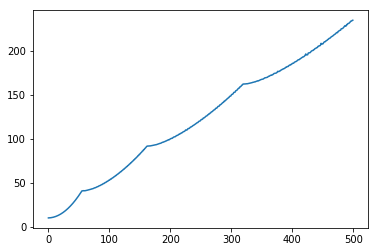

In [517]:
plt.plot(evaL[4])

In [ ]:
#No windowing no binning
a,b,dI_dV,E = Average_dI_dV_T(abs_evecs[4],evaL[4],binning=23,overlap=22)
plt.plot(np.diff(E),'.')
plot_di_dv(dI_dV,E)
plot_spectra(dI_dV,E,vmin=0,vmax=0.0005)
plot_QPI(dI_dV,E,vmin=-10,vmax=-0.5)

In [ ]:
#No windowing no binning
a,b,dI_dV1,E1 = Average_dI_dV_T(abs_evecs[4],evaL[4],binning=6,overlap=5)
plt.plot(np.diff(E1),'.')
plot_di_dv(dI_dV1,E1)
plot_spectra(dI_dV1,E1,vmin=0,vmax=0.01)
plot_QPI(dI_dV1,E1,vmin=-6,vmax=0.02)

In [ ]:
np.shape(evaL[4])

In [ ]:
#WIDTH CALCULATION

#Plotting the spatial spectra, QPI, averaged di/dv of a finite wire of length L width w, with spacing a
#hopping term t. the k first eigen function are to be considered and the leads are of the same hoppin term
#as wire.
a=1.0
t=1.0
nt=1.0
L=400
w1=10
w2=30
W0=5
leads=-1
k=200
sys0,X0,tot0,eva0,di_dV0=get_wire_density_energy(a,t,nt,L,W0,leads,k)
#kwant.plot(sys)
kwant.plotter.map(sys0, tot0[:,27], colorbar=True)
plot_spectra(X0,eva0,L)
plot_QPI(X0,eva0,L,-5,-1)
#plot_QPI_bokeh(X,eva,L,-3.2,-1)
plot_di_dv(X0,eva0,L)
plt.show()

In [ ]:
dI_dV,EE=Average_dI_dV(X_1,eva)
#sorting_idx=np.argsort(eva)
#sorted_eva=eva[sorting_idx]

In [ ]:
plot_spectra(dI_dV,EE,3000,vmin=0,vmax=0.07)

In [ ]:
binning=1
overlap=0
X=X_1

eva_len=len(eva)
x_len=np.shape(X)[1]
sorting_idx=np.argsort(eva)
sorted_eva=eva[sorting_idx]
X_sorted=X[(sorting_idx),:]
movement=int(binning-overlap)
energy_count_size=int(np.ceil(float(eva_len-binning)/float(movement))+1)
energy_count_size_orig=np.ceil(float(eva_len)/float(binning))
X_binned=np.zeros((energy_count_size,x_len));
avg_energies=np.zeros(energy_count_size);
first_energy=sorted_eva[0];
second_energy=0;
j=binning-1;
i=0;
while j<=eva_len-1:
    first_idx=j-binning+1;
    first_energy=sorted_eva[first_idx];
    second_energy=sorted_eva[j];
    avg_energies[i]=np.mean(sorted_eva[first_idx:j+1]);
    X_binned[i,:]=np.mean(X_sorted[first_idx:j+1,:],0);
    j=j+movement;
    i=i+1;
if j<(eva_len+movement-1):
    num=binning-(j-eva_len+1);
    first_idx=j-num;
    first_energy=sorted_eva[first_idx];
    second_energy=sorted_eva[-1];
    avg_energies[i]=mean(sorted_eva[first_idx:]);
    X_binned[i,:]=mean(X_sorted[first_idx:,:],0);
dE=np.diff(avg_energies);
dX_binned=np.diff(X_binned,axis=0);
dNx_dE=dX_binned/dE[:,None] #Weird syntex;
dNx_dE=dNx_dE*float(energy_count_size_orig/energy_count_size);
avg_E_final=np.mean([avg_energies[:-1],avg_energies[1:]],axis=0);


In [ ]:
#plt.figure();
#plt.plot(avg_E_final,dNx_dE[:,1500],'.')
#np.shape(avg_E_final)
#plt.figure();

#plt.plot(list(range(3000)),dNx_dE[0,:],'.')
plt.figure();
plt.plot(list(range(3000)),X[1,:],'.')
#plt.figure();
#plt.plot(list(range(3000)),X_sorted[1,:],'.')

In [ ]:
plt.figure();
plt.plot(list(range(3000)),X_sorted[1,:]-X_sorted[0,:],'.')
plt.figure();
plt.plot(list(range(3000)),dX_binned[0,:],'.')
val, idx = min((val,idx) for (idx,val) in enumerate(eva))

In [ ]:
X_1=np.zeros(np.shape(X))
X_1[0,:] = X[0,:]
for i in range(1,len(eva)):
    X_1[i,:]=X[i,:]-X[i-1,:];
    current=X[i,:];

In [ ]:
np.min(X[1,:])

In [ ]:
x_axis=np.linspace(0,L,L);
#x_axis=x_axis-np.mean(x_axis);
p=figure(x_range=(min(x_axis),max(x_axis)),y_range=(min(eva),max(eva)))
p.image(image=[X],x=x_axis,y=eva,dw=L,dh=max(eva),color_mapper=color_mapper)
np.max(X)-np.min(X)
color_mapper = LinearColorMapper(palette="Viridis256")
color_bar = ColorBar(color_mapper=color_mapper,
                     label_standoff=12, border_line_color=None, location=(0,0))
p.add_layout(color_bar, 'left')
show(p)


In [ ]:
w1=10
w2=30
syst_finite,eve,eva=get_wire_density_energy(a,t,nt,L,W,leads,k,False,w1,w2)

In [ ]:
kwant.plot(syst_finite);
total_density = np.sum(np.abs(eve)**2,1);
kwant.plotter.map(syst_finite, total_density, colorbar=False);

In [ ]:
plot_spectra(total_density_avg,eva,L)

In [ ]:
delta=0
L=3000
a=1
window=False;
vmin=-8
vmax=-0.1



delta_abs=int(L*delta/2)
L_abs=int(L-2*delta_abs)
X_1=X[:,delta_abs:L-delta_abs]
X_2=np.zeros(X_1.shape)
real_axis=np.linspace(0,a,L)
if window:
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X_2[i,j]=X_1[i,j]*np.sin(np.pi*(j*a)/(L_abs))
    DATA=np.log(np.abs(np.fft.fftshift(np.fft.fft(X_2,axis=1),axes=1)))
else:
    DATA=np.log(np.abs(np.fft.fftshift(np.fft.fft(X_1,axis=1),axes=1)))
x_axis=np.linspace(0,2*np.pi/a,2*(L_abs))
x_axis=x_axis-np.mean(x_axis)
for j in range(len(DATA[:,0])):
    DATA[j,int(DATA.shape[1]/2)]=(DATA[j,int(DATA.shape[1]/2)-1]+DATA[j,int(DATA.shape[1]/2)+1])/2
fig,ax = plt.subplots(figsize=(10,10))
cax=ax.imshow(DATA,origin='lower',extent=[np.min(x_axis),np.max(x_axis),np.min(eva),np.max(eva)],aspect='auto',vmin=vmin,vmax=vmax)
plt.colorbar(cax)
plt.ylabel('Energy')
plt.xlabel('q[2*pi/a]')
plt.title('E vs. q', fontsize=20)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.show()
#

In [ ]:
np.shape(np.append(dE,3))

In [ ]:
plot_spectra(X1,eva1,L)
plot_QPI(X1,eva1,L,-3.2,-1)
#plot_QPI_bokeh(X,eva,L,-3.2,-1)
plot_di_dv(X1,eva1,L)
plt.show()

In [ ]:
#WIDTH CALCULATION

#Plotting the spatial spectra, QPI, averaged di/dv of a finite wire of length L width w, with spacing a
#hopping term t. the k first eigen function are to be considered and the leads are of the same hoppin term
#as wire.
a=1
t=1
nt=1
L=400
w1=10
w2=30
W0=5
leads=-1
k=200
sys0,X0,tot0,eva0=get_wire_density_energy(a,t,nt,L,W0,leads,k)
#kwant.plot(sys)
#kwant.plotter.map(sys, tot[:,27], colorbar=True)
plot_spectra(X0,eva0,L)
plot_QPI(X0,eva0,L,-3.2,-1)
#plot_QPI_bokeh(X,eva,L,-3.2,-1)
plot_di_dv(X0,eva0,L)
plt.show()

In [ ]:
#Plotting the spatial spectra, QPI, averaged di/dv of a finite wire of length L width w, with spacing a
#hopping term t. the k first eigen function are to be considered and the leads are of the same hoppin term
#as wire.
a=1
t=1
nt=1
L=400
w1=10
w2=30
W1=10
leads=-1
k=200
sys1,X1,tot1,eva1=get_wire_density_energy(a,t,nt,L,W1,leads,k)
#kwant.plot(sys)
#kwant.plotter.map(sys, tot[:,27], colorbar=True)
plot_spectra(X1,eva1,L)
plot_QPI(X1,eva1,L,-3.2,-1)
#plot_QPI_bokeh(X,eva,L,-3.2,-1)
plot_di_dv(X1,eva1,L)
plt.show()

In [ ]:
#Plotting the spatial spectra, QPI, averaged di/dv of a finite wire of length L width w, with spacing a
#hopping term t. the k first eigen function are to be considered and the leads are of the same hoppin term
#as wire.
a=1
t=1
nt=1
L=400
w1=10
w2=30
W2=20
leads=-1
k=200
#sys2,X2,tot2,eva2=get_wire_density_energy(a,t,nt,L,W2,leads,k)
#kwant.plot(sys)
#kwant.plotter.map(sys, tot[:,27], colorbar=True)
plot_spectra(X2,eva2,L)
plot_QPI(X2,eva2,L,-3.2,-1)
#plot_QPI_bokeh(X,eva,L,-3.2,-1)
plot_di_dv(X2,eva2,L)
plt.show()

In [ ]:
#Plotting the spatial spectra, QPI, averaged di/dv of a finite wire of length L width w, with spacing a
#hopping term t. the k first eigen function are to be considered and the leads are of the same hoppin term
#as wire.
a=1
t=1
nt=1
L=400
w1=10
w2=30
W3=30
leads=-1
k=200
sys3,X3,tot3,eva3=get_wire_density_energy(a,t,nt,L,W3,leads,k)
#kwant.plot(sys)
#kwant.plotter.map(sys, tot[:,27], colorbar=True)
plot_spectra(X3,eva3,L)
plot_QPI(X3,eva3,L,-3.2,-1)
#plot_QPI_bokeh(X,eva,L,-3.2,-1)
plot_di_dv(X3,eva3,L)
plt.show()

In [ ]:
#Plotting the spatial spectra, QPI, averaged di/dv of a finite wire of length L width w, with spacing a
#hopping term t. the k first eigen function are to be considered and the leads are of the same hoppin term
#as wire.
a=1
t=1
nt=1
L=400
w1=10
w2=30
W4=40
leads=-1
k=200
#sys4,X14,tot4,eva4=get_wire_density_energy(a,t,nt,L,W4,leads,k)
#kwant.plot(sys)
#kwant.plotter.map(sys, tot[:,27], colorbar=True)
plot_spectra(X14,eva4,L)
plot_QPI(X14,eva4,L,-5,-2.5)
#plot_QPI_bokeh(X,eva,L,-3.2,-1)
plot_di_dv(X14,eva4,L)
plt.show()

In [ ]:
AB=np.diff(X14,axis=0)
AC=np.diff(eva)
X14_NEW = np.zeros((199,400))
for i in range(400):
    X14_NEW[:,i]=np.divide(AB[:,i],AC)
        plot_QPI(XL[i],evaL[i],Lsize[i],-5,-1)

In [ ]:
plt.figure(figsize=(10,10))
Y=(np.mean(XL[5],1))
Ya=np.diff(Y)
Yc=np.diff(evaL[5])
Yc1=Ya/Yc
plt.plot((evaL[5])[:-1],Yc1) #averaging X

plt.figure(figsize=(10,10))
plt.plot(evaL[5],Y) #averaging X

In [ ]:
plot_di_dv(X14,eva4,L)
plot_di_dv(X3,eva3,L)
plot_di_dv(X2,eva2,L)
plot_di_dv(X1,eva1,L)

In [ ]:
plot_spectra(X0,eva0,L)
plot_spectra(X1,eva1,L)
plot_spectra(X2,eva2,L)
plot_spectra(X3,eva3,L)
plot_spectra(X14,eva4,L)

In [ ]:
plot_QPI(X0,eva0,L,-5,-1)
plot_QPI(X1,eva1,L,-5,-1)
plot_QPI(X2,eva2,L,-5,-1)
plot_QPI(X3,eva3,L,-5,-1)
plot_QPI(X14,eva4,L,-5,-1)

In [ ]:
#sysN,XN,totN,evaN,eveN=get_wire_density_energy(a,t,nt,L,30,leads,k)
plot_QPI(XN,evaN,L,-5,-1)
plot_di_dv(XN,evaN,L)

In [ ]:
#End of width variation
a=1.0
t=1.0
nt=1.0
leads=-1
sysL= [None]*6
XL = [None]*6
totL = [None]*6
evaL = [None]*6
abs_evecs=[None]*6

Lsize = [200,400,600,800,1000,3000]
kL = [100,200,300,400,500,3000]
w=30

for i in pyprind.prog_percent(range(1)):
    sysL[i], XL[i], totL[i], evaL[i], abs_evecs[i] = get_wire_density_energy(a,t,nt,Lsize[i],w,leads,kL[i])

In [ ]:
plt.plot(np.diff(evaL[]),'.')

In [ ]:
XB,dE,dIV, EE = Average_dI_dV_T(abs_evecs[1],evaL[1],binning=2,overlap=0)
#dIV, EE = Average_dI_dV(abs_evecs[4],evaL[4],binning=1,overlap=0)

In [ ]:
#plot_spectra(dIV,EE,200,vmin=0,vmax=40)
plot_spectra(dIV,EE,400)

In [ ]:
cur_E=evaL[0]
#plot_di_dv(dIV,EE,200)
#np.size(EE)
plt.plot(cur_E[1:],1./A,'.') #averaging X

In [ ]:
cur=abs_evecs[0]
for i in range(6):
    plt.plot(list(range(200)),cur[i,:])

In [ ]:
#ham_mat = sysL[0].hamiltonian_submatrix(sparse=True)
#eigenes,evecs = sla.eigsh(ham_mat, k=100, which='SM')
#evecs = evecs(space,energy)
length=evecs.shape[1]
evecs1=np.zeros(evecs.shape,dtype=complex)
for i in range(length):
    a=np.sqrt(np.sum(np.abs(evecs[:,i])**2))
    evecs1[:,i]=evecs[:,i]/a

In [ ]:
#Changing the length
for i in range(6):
    plot_QPI(XL[i],evaL[i],Lsize[i],-5,-1)

In [ ]:
for i in range(6):
    plot_di_dv(XL[i],evaL[i],Lsize[i])

In [ ]:
#Base energy almost doesn't change for this aspect ratio (~0.1% change)
plt.figure()
plt.plot([(evaL[0])[0],evaL[1][0],evaL[2][0],evaL[3][0],evaL[4][0],evaL[5][0]],'.')
plt.show()

In [ ]:
#periodic system
w_no=30
L=1000
k=500
sys_nno,XL_no, totL_no, evaL_no = get_wire_density_energy(a,t,nt,L,w_no,leads,k,is_periodic=True)
sys_nno_1,XL_no_1, totL_no_1, evaL_no_1 = get_wire_density_energy(a,t,nt,L,w_no,leads,k,is_periodic=False)

In [ ]:
plot_QPI(XL_no,evaL_no,L,-6.1,-3,delta=0.01)
plot_QPI(XL_no_1,evaL_no_1,L,-6.1,-3,delta=0.1)

In [ ]:
plot_spectra(np.diff(XL_no,axis=0),evaL_no,L)
plot_spectra(np.diff(XL_no_1,axis=0),evaL_no_1,L)

In [ ]:
#Windowing
plot_QPI(XL[3],evaL[3],Lsize[3],-0.00001,-0.0000001,0,window=True)
plot_QPI(XL[3],evaL[3],Lsize[3],-0.00001,-0.0000001,0,window=False)
plot_QPI(XL[3],evaL[3],Lsize[3],-0.00001,-0.0000001,0.1)
plot_QPI(XL[3],evaL[3],Lsize[3],-0.00001,-0.0000001,0.2)
plot_QPI(XL[3],evaL[3],Lsize[3],-0.00001,-0.0000001,0.3)
plot_QPI(XL[3],evaL[3],Lsize[3],-0.00001,-0.0000001,0.4)
plot_QPI(XL[3],evaL[3],Lsize[3],-0.00001,-0.0000001,0.5)
plot_QPI(XL[3],evaL[3],Lsize[3],-0.00001,-0.0000001,0.6)
plot_QPI(XL[3],evaL[3],Lsize[3],-0.00001,-0.0000001,0.7)
plot_QPI(XL[3],evaL[3],Lsize[3],-0.00001,-0.0000001,0.8)
plot_QPI(XL[3],evaL[3],Lsize[3],-0.00001,-0.0000001,0.9)


In [ ]:
k=200
L=400
delta_abs=14
#ax = kwant.plotter.map(sys, tot[:,27], colorbar=False,fig_size=(13,13))
f, ax = plt.subplots(10,3,figsize=(13,16),sharey=True)
f.subplots_adjust(hspace=1.1,wspace=0.05)
TDA=np.zeros(shape=(W3,k,L))
for j in range(W3):
    for i in range(len(eva)):
        A=tot3[:,i].reshape(-1,W3)
        #TDA[i,:] = np.mean(A[:,delta_abs:(W3-delta_abs)]) #averaged over y
        TDA[j,i,:] = np.mean(A[:,j]) #averaged over y
for j in range(3):
    for i in range(10):
        plot_di_dv(TDA[j*10+i],eva3,L,ax=ax[i,j],title=j*10+1+i,ylabel='',xlabel='')
#plot_di_dv(TDA,eva3,L)  

In [ ]:
k=200;
L=400
delta_abs=5
TDA=np.zeros(shape=(k,L))
for i in range(len(eva)):
    A=tot3[:,i].reshape(-1,W3)
    TDA[i,:] = np.mean(A[:,delta_abs:(W3-delta_abs)]) #averaged over y
plot_di_dv(TDA,eva3,L)

In [ ]:
k=200;
L=400
delta_abs=10
TDA=np.zeros(shape=(k,L))
for i in range(len(eva)):
    A=tot3[:,i].reshape(-1,W3)
    TDA[i,:] = np.mean(A[:,delta_abs:(W3-delta_abs)]) #averaged over y
plot_di_dv(TDA,eva3,L)

In [ ]:
k=200;
L=400
delta_abs=14
TDA=np.zeros(shape=(k,L))
for i in range(len(eva)):
    A=tot3[:,i].reshape(-1,W3)
    TDA[i,:] = np.mean(A[:,delta_abs:(W3-delta_abs)]) #averaged over y
plot_di_dv(TDA,eva3,L)

In [ ]:
#Saving to matlab so I can extrapolate easily
sio.savemat('a.mat',{'X':XL[5]})
sio.savemat('b.mat',{'tot':totL[5]})
sio.savemat('c.mat',{'eva':evaL[5]})

In [ ]:
#Saving to matlab so I can extrapolate easily
X=sio.loadmat('a.mat')['X']
tot=sio.loadmat('b.mat')['tot']
eva=sio.loadmat('c.mat')['eva']
eva=eva[0]

In [ ]:
plot_QPI(X,eva,3000)

In [ ]:
#checcking limits
sysF= [None]
XF = [None]
totF = [None]
evaF = [None]
LsizeF = 3000
kF =1500
wF=50
sysF, XF, totF, evaF = get_wire_density_energy(a,t,nt,LsizeF,wF,leads,kF)

In [ ]:
eveN1=eveN0/np.sum(np.abs(eveN)**2,0)

In [ ]:
eveN.shape

In [ ]:
length=eveN.shape[1]
eveN1=np.zeros(eveN.shape,dtype=complex)
for i in range(length):
    a=np.sqrt(np.sum(np.abs(eveN[:,i])**2))
    eveN1[:,i]=eveN[:,i]/a

In [ ]:
total_density = np.sum(np.abs(eveN1)**2,1);

In [ ]:
eveN1.shape

In [ ]:
eveN1.shape

In [ ]:
(np.sqrt(np.sum(np.abs(eveN[:,80])**2)))

In [ ]:
eveN[:,0]=eveN[:,0]/1.2

In [ ]:
C=list(range(10))

In [ ]:
C[1:3:2]

In [ ]:
AA=evaL[0]
print((evaL[0])[0],evaL[1][0],evaL[2][0],evaL[3][0],evaL[4][0],evaL[5][0])

In [ ]:
plt.figure()
plt.plot([(evaL[0])[0],evaL[1][0],evaL[2][0],evaL[3][0],evaL[4][0],evaL[5][0]],'.')
plt.show()

In [ ]:
plt.figure()
dist=[(eva0[0]-(np.pi/5.0)**2)/((np.pi/5.0)**2),(eva1[0]-(np.pi/10.0)**2)/((np.pi/10.0)**2),(eva2[0]-(np.pi/20.0)**2)/((np.pi/20.0)**2),(eva3[0]-(np.pi/30.0)**2)/((np.pi/30.0)**2),(eva4[0]-(np.pi/40.0)**2)/((np.pi/40.0)**2)]
dist=np.abs(dist)
plt.plot(dist,'.')
plt.show()

In [ ]:
def calc_eigen(syst_finite,k):
    ham_mat = syst_finite.hamiltonian_submatrix(sparse=True)
    print(int(np.shape(ham_mat)[0]*0.5))
    #eigenes,evecs = sla.eigsh(ham_mat, k=k, which='SM',tol=10**(-32),ncv=800)
    eigenes,evecs = sla.eigsh(ham_mat.tocsc(), k=k, which='SM')
    length=evecs.shape[1]
    evecs1=np.zeros(evecs.shape,dtype=complex)
    for i in range(length):
        a=np.sqrt(np.sum(np.abs(evecs[:,i])**2))
        evecs1[:,i]=evecs[:,i]/a
    return syst_finite,evecs,eigenes

    
def get_wire_density_energy(a,t,nt,L,W,leads,k,is_Normal=True,w1=10,w2=30,is_periodic=False,delta_y=0): 
    delta_abs=int(W*delta_y/2)
    W_abs=int(W-2*delta_abs)
    total_density_avg=np.zeros(shape=(k,L))
    if is_Normal:
        syst_finite,eve,eva= get_normal_eigen(a,t,nt,L,W,leads,k,is_periodic)
        temp=np.zeros(shape=(L*W,k))
        for i in range(len(eva)):
            temp[:,i] = np.sum(np.abs(eve[:,:(i+1)])**2,1)
            A=temp[:,i].reshape(-1,W)
            total_density_avg[i,:] = np.mean(A[:,delta_abs:(W-delta_abs)]) #averaged over y
    else:
        syst_finite,eve,eva= get_trapazoide_eigen(a,t,nt,L,w1,w2,leads,k)
        temp=np.zeros(shape=(eve.shape[0],k))
        for i in range(len(eva)):
            temp[:,i] = np.sum(np.abs(eve[:,:(i+1)])**2,1)
            #total_density_avg[i,:] = np.mean(temp[:,i].reshape(-1,W),axis=1) #averaged over y
    return syst_finite,total_density_avg,temp,eva

In [ ]:
#End of width variation
a=1.0
t=1.0
nt=4.0
leads=-1
sysLT= None
XLT = None
totLT = None
evaLT = None
evaLT2 = None
LsizeT = 600
kLT = 100
w=30
sysLT, XLT, totLT, evaLT2, hem = get_wire_density_energy(a,t,nt,LsizeT,w,leads,kLT)
#hem = get_wire_density_energy(a,t,nt,LsizeT,w,leads,kLT)

In [ ]:
A=hem.tocsc()
type(A)

In [ ]:

#A=evaL[2];
#A=A[1:100];
#plt.figure()
#plt.plot(np.diff(A),'.')
plt.figure()
plt.plot(np.diff(evaLT2),'.')
plt.title('800')

In [ ]:
plt.figure()
plt.plot((evaLT2-evaLT1),'.',[0,10**(-6)])

In [ ]:
import scipy
scipy.__version__

In [ ]:
np.append(np.array([1,2,4]),7)

In [539]:
#trapazoide wire
a=1.0
t=1000.0
nt=1.0
leads=-1
sysT= [None]*6
XT = [None]*6
totT = [None]*6
evaT = [None]*6
abs_evecsT=[None]*6
LsizeT = [200,400,600,800,1000,3000]
kLT = [100,200,300,400,500,1500]
w1=10
w2=30
for i in pyprind.prog_percent(range(6)):
    sysT[i], XT[i], totT[i], evaT[i], abs_evecsT[i], c, d=get_wire_density_energy(a,t,nt,LsizeT[i],20,leads,kLT[i],is_Normal=False,w1=w1,w2=w2)

[100 %] Time elapsed: 08:04:15 | ETA: 00:00:00
Total time elapsed: 08:04:15


In [ ]:
a,b,dI_dV,E = Average_dI_dV_T(abs_evecsT[4],evaT[4],binning=35,overlap=34)
plot_di_dv(dI_dV,E)
plot_spectra(dI_dV,E,vmin=0,vmax=0.0001)
plot_QPI(dI_dV,E,vmin=-10,vmax=-4)

In [ ]:
a,b,dI_dV,E = Average_dI_dV_T(abs_evecsT[4],evaT[4],binning=4,overlap=3)
plot_di_dv(dI_dV,E)
plot_spectra(dI_dV,E,vmin=0,vmax=0.004)
plot_QPI(dI_dV,E,vmin=-5,vmax=0)

In [ ]:
a,b,dI_dV,E = Average_dI_dV_T(abs_evecsT[4],evaT[4],binning=1,overlap=0)
plot_di_dv(dI_dV,E)
plot_spectra(dI_dV,E,vmin=0,vmax=0.009)
plot_QPI(dI_dV,E,vmin=-4,vmax=3)

594.0 200.0 200.0 0.3383838383838384 1.00440034185
894.0 300.0 300.0 0.33557046979865773 0.498918382265
1194.0 400.0 400.0 0.33668341708542715 0.154499777145
4494.0 1500.0 1500.0 0.33377837116154874 0.0584368853787


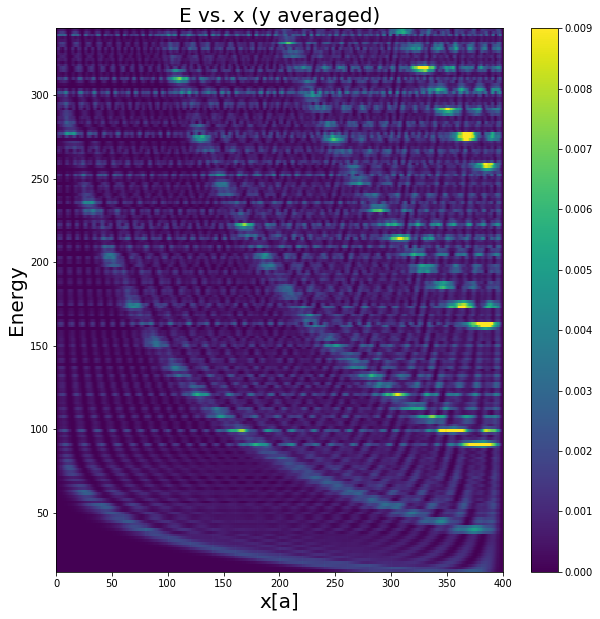

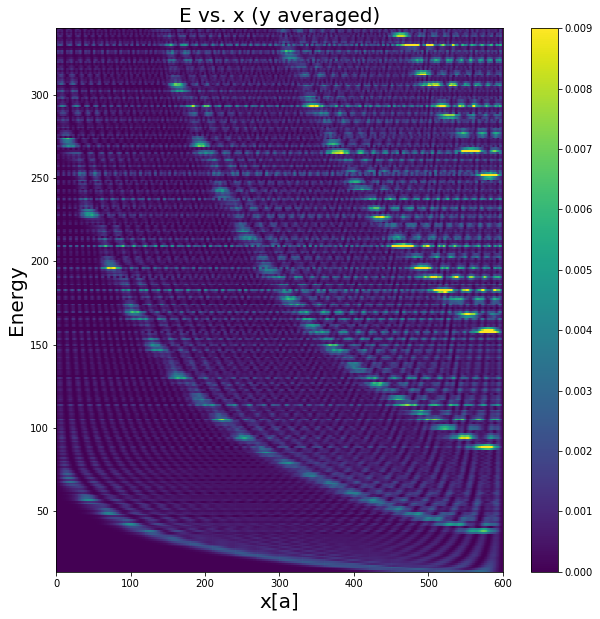

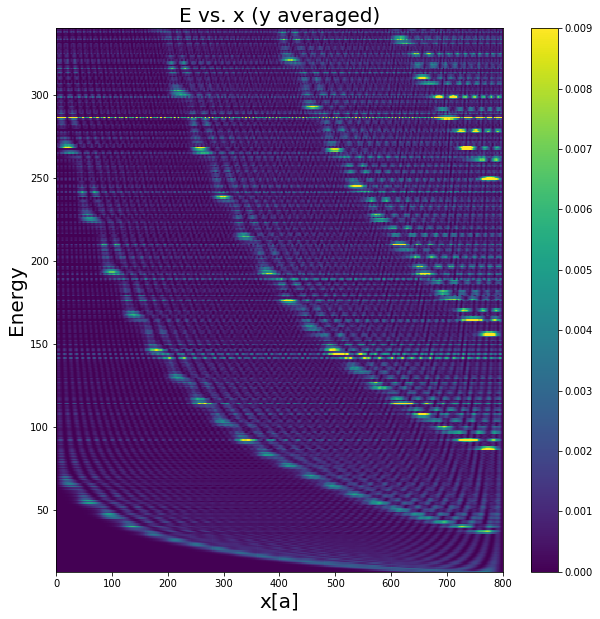

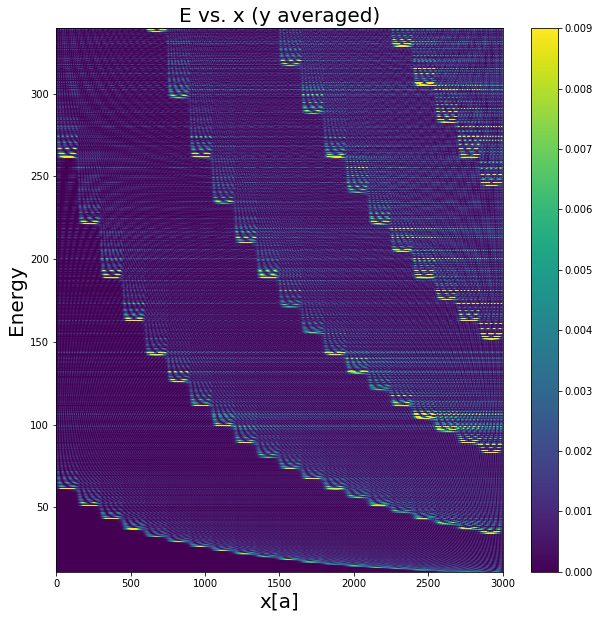

In [543]:
#%matplotlib inline
#print(plt.swi_backend())
a,b,dI_dV,E = Average_dI_dV_T(abs_evecsT[1],evaT[1],binning=3,overlap=2)
a,b,dI_dV1,E1 = Average_dI_dV_T(abs_evecsT[2],evaT[2],binning=3,overlap=2)
a,b,dI_dV2,E2 = Average_dI_dV_T(abs_evecsT[3],evaT[3],binning=3,overlap=2)
a,b,dI_dV3,E3 = Average_dI_dV_T(abs_evecsT[5],evaT[5],binning=3,overlap=2)

#plot_di_dv(dI_dV,E)
#plot_spectra(dI_dV,E,vmin=0,vmax=0.009)
plot_spectra(dI_dV,E,vmin=0,vmax=0.009)
plot_spectra(dI_dV1,E1,vmin=0,vmax=0.009)
plot_spectra(dI_dV2,E2,vmin=0,vmax=0.009)
plot_spectra(dI_dV3,E3,vmin=0,vmax=0.009)

In [ ]:
kwant.plot(sysT[1])
kwant.plot(sysT[2])
kwant.plot(sysT[3])
kwant.plot(sysT[4])

1500.0 1500.0 1500.0 1.0 0.00326539154671


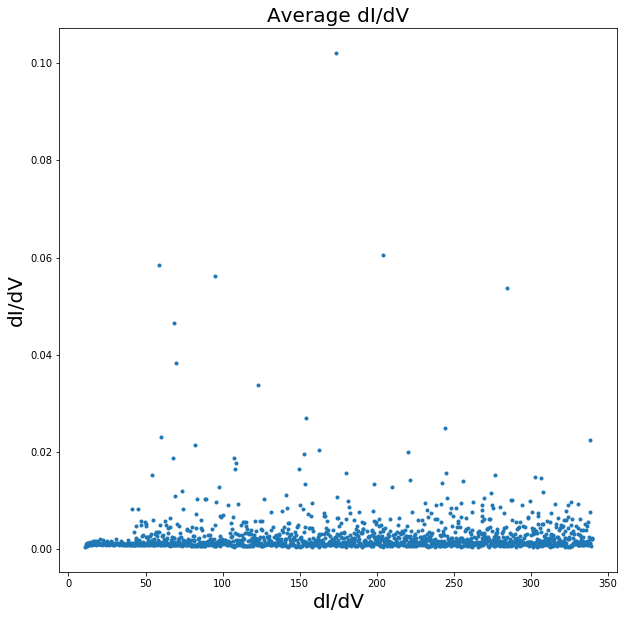

In [565]:
a,b,dI_dV3,E3 = Average_dI_dV_T(abs_evecsT[5],evaT[5],binning=1,overlap=0)

plot_di_dv(dI_dV3,E3)

200.0 200.0 200.0 1.0 1.00440034185
300.0 300.0 300.0 1.0 0.561050759977
400.0 400.0 400.0 1.0 0.0
500.0 500.0 500.0 1.0 0.202748522376


/home/tom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:291: RuntimeWarning: divide by zero encountered in true_divide
/home/tom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in true_divide


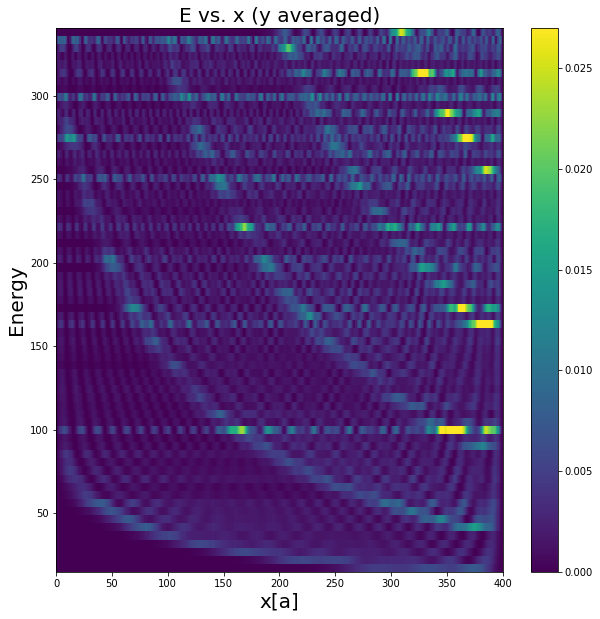

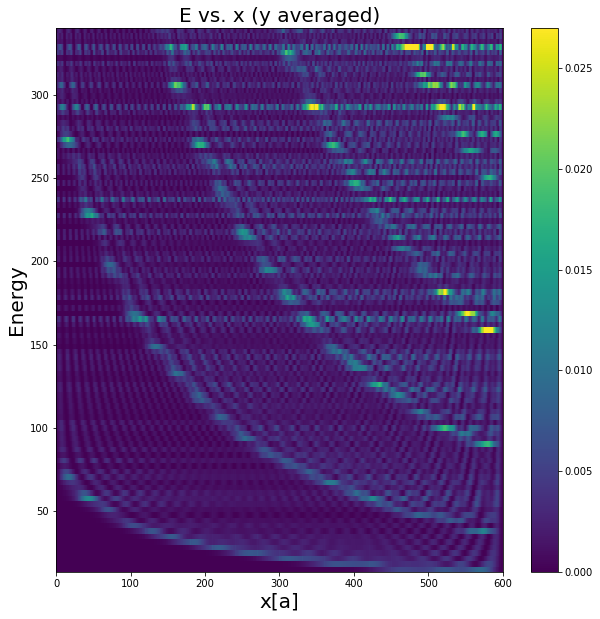

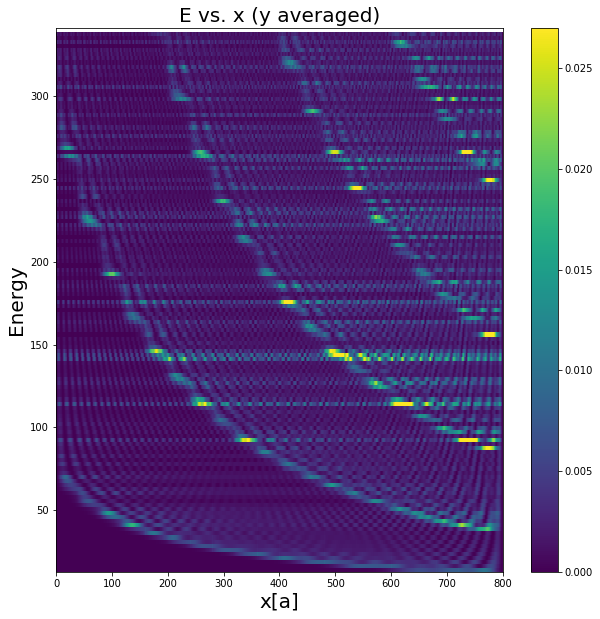

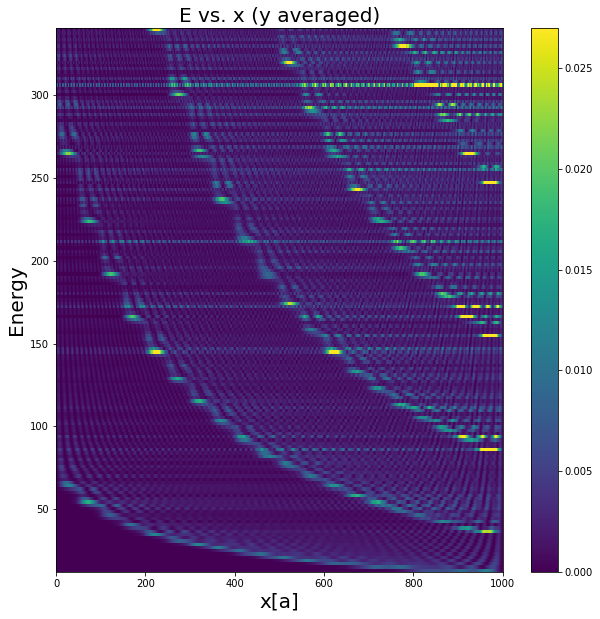

In [538]:
a,b,dI_dV,E = Average_dI_dV_T(abs_evecsT[1],evaT[1],binning=3,overlap=0)
a,b,dI_dV1,E1 = Average_dI_dV_T(abs_evecsT[2],evaT[2],binning=3,overlap=0)
a,b,dI_dV2,E2 = Average_dI_dV_T(abs_evecsT[3],evaT[3],binning=3,overlap=0)
a,b,dI_dV3,E3 = Average_dI_dV_T(abs_evecsT[4],evaT[4],binning=3,overlap=0)

#plot_di_dv(dI_dV,E)
#plot_spectra(dI_dV,E,vmin=0,vmax=0.009)
plot_spectra(dI_dV,E,vmin=0,vmax=0.027)
plot_spectra(dI_dV1,E1,vmin=0,vmax=0.027)
plot_spectra(dI_dV2,E2,vmin=0,vmax=0.027)
plot_spectra(dI_dV3,E3,vmin=0,vmax=0.027)


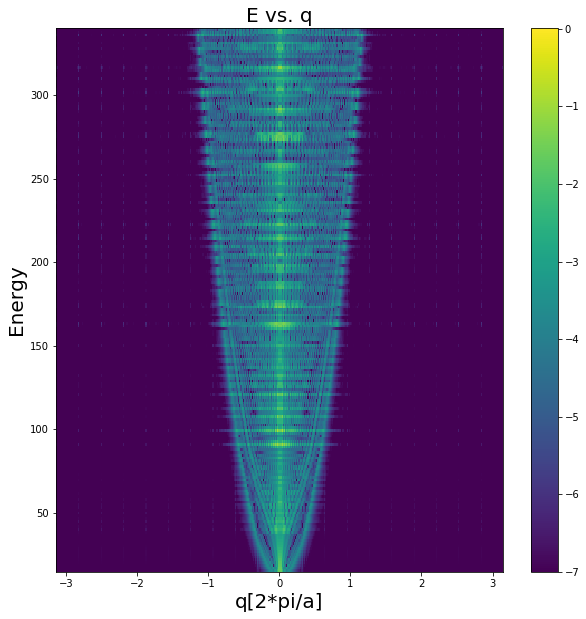

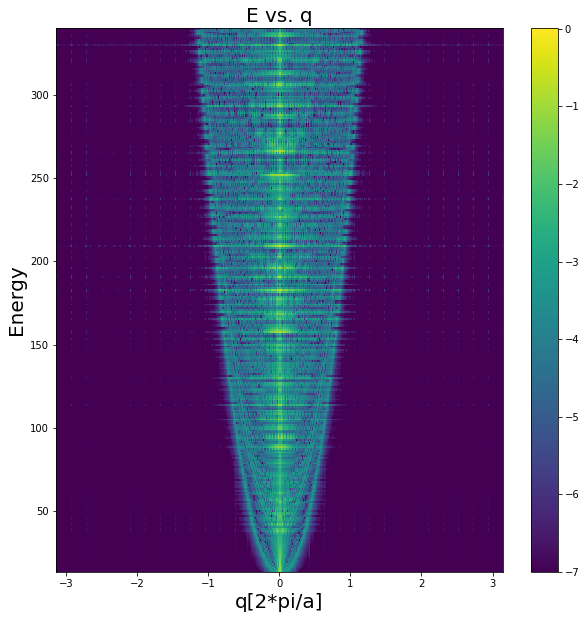

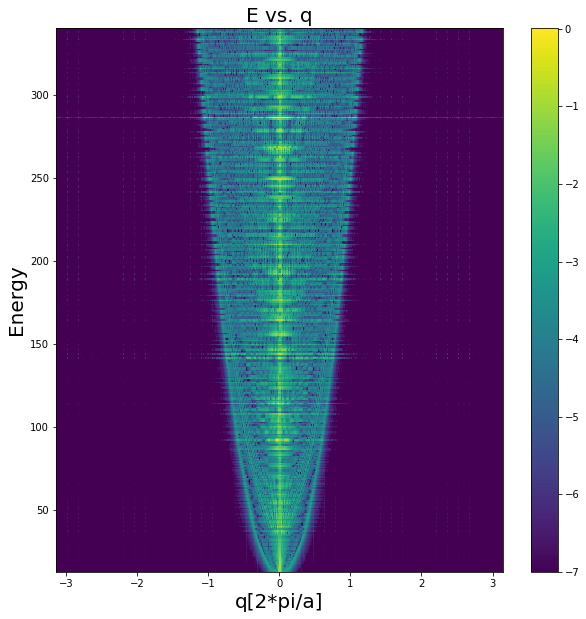

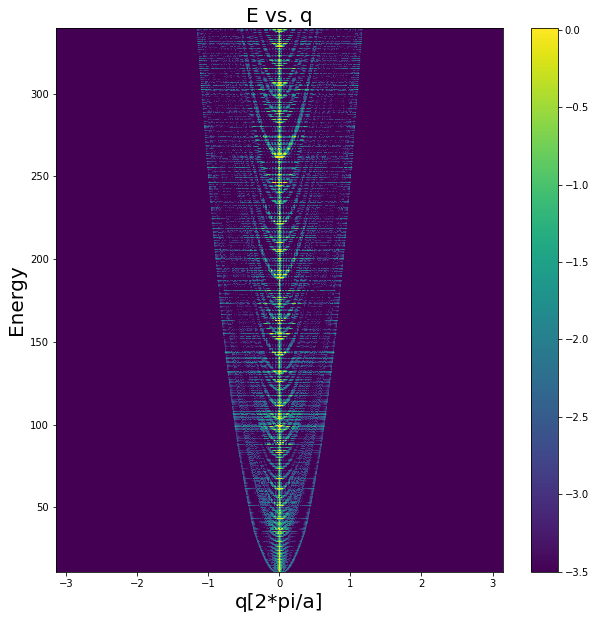

In [547]:
plot_QPI(dI_dV,E,vmin=-7,vmax=0.009)
plot_QPI(dI_dV1,E1,vmin=-7,vmax=0.009)
plot_QPI(dI_dV2,E2,vmin=-7,vmax=0.009)
plot_QPI(dI_dV3,E3,vmin=-3.5,vmax=0.009)

In [515]:

#Saving to matlab so I can extrapolate easily
sio.savemat('a.mat',{'dI_dV':dI_dV,'E':E})
sio.savemat('a1.mat',{'dI_dV1':dI_dV1,'E1':E1})
sio.savemat('a2.mat',{'dI_dV2':dI_dV2,'E2':E2})
sio.savemat('a3.mat',{'dI_dV3':dI_dV3,'E3':E3})

3620.0 200.0 200.0 0.055248618784530384 27.6446186112
5620.0 300.0 300.0 0.05338078291814947 18.7252827882
7620.0 400.0 400.0 0.05249343832020997 13.4837876673
9620.0 500.0 500.0 0.05197505197505198 10.3281782865


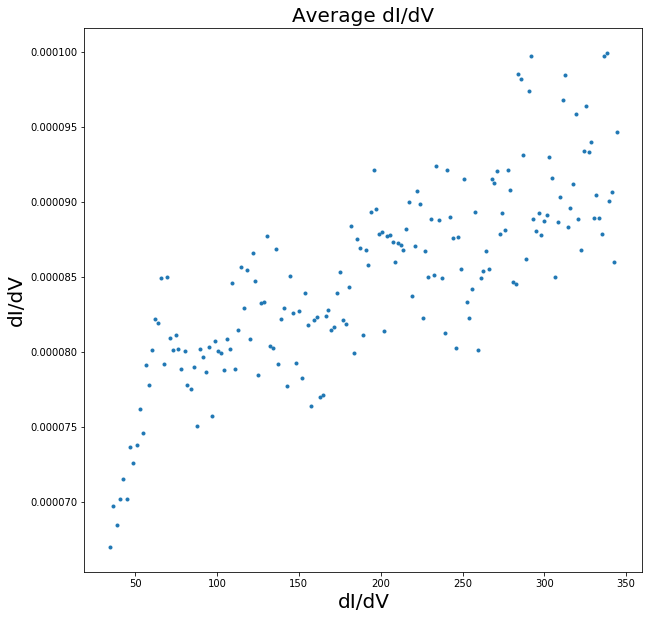

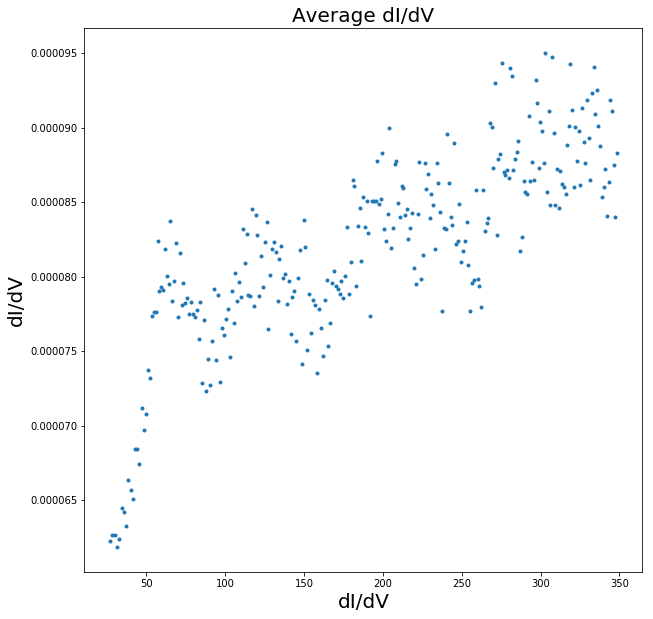

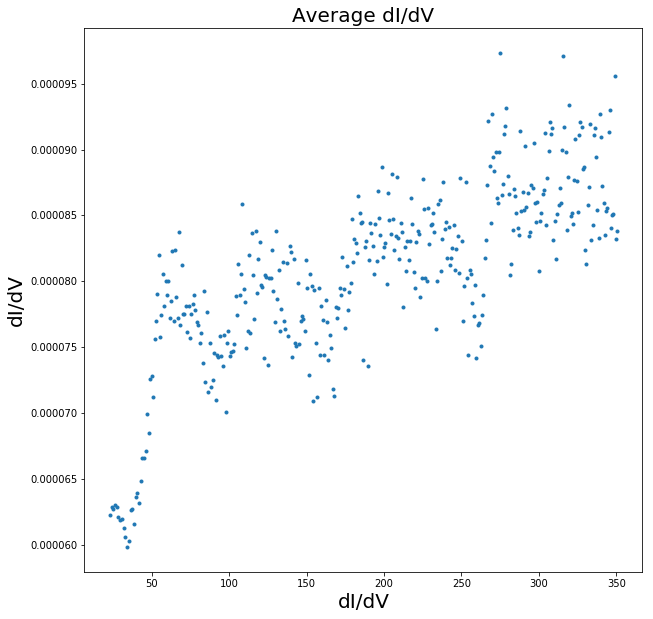

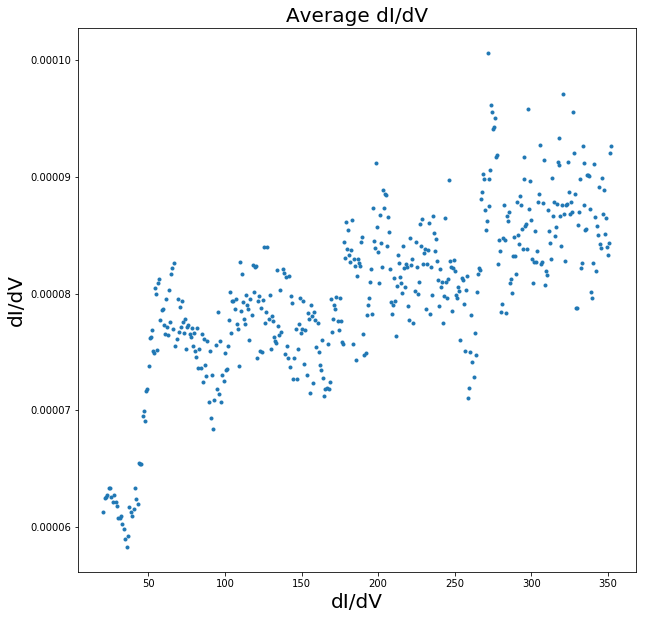

In [481]:
a,b,dI_dV,E = Average_dI_dV_T(abs_evecsT[1],evaT[1],binning=20,overlap=19)
a,b,dI_dV1,E1 = Average_dI_dV_T(abs_evecsT[2],evaT[2],binning=20,overlap=19)
a,b,dI_dV2,E2 = Average_dI_dV_T(abs_evecsT[3],evaT[3],binning=20,overlap=19)
a,b,dI_dV3,E3 = Average_dI_dV_T(abs_evecsT[4],evaT[4],binning=20,overlap=19)
plot_di_dv(dI_dV,E)
plot_di_dv(dI_dV1,E1)
plot_di_dv(dI_dV2,E2)
plot_di_dv(dI_dV3,E3)

In [ ]:
L=1000
w1=10
we=30
a=1
total_length=np.zeros(L-1)

def Trapazoide(pos):
    (x, y) = pos
    return ((0 < x < L) and (0 < y < (((w2-w1)/L)*x+w1)))
lat = kwant.lattice.square(a)
aa=lat.shape(Trapazoide, (L-1,1))
AA=list(aa())
#density_per_energy = np.zeros(eve.shape)
for i in range(len(AA)):
    #Counting the length of each collun
    T=AA[i];
    (x,y)=T[1];
    total_length[x-1]=total_length[x-1]+1

In [ ]:
np.diff(total_length)
indices= [i for i,x in enumerate(np.diff(total_length)) if x==1]
indices

In [ ]:
#testing if it makes sense
a=1.0
t=1000.0
nt=1.0
leads=-1
sysTr= None
XTr = None
totTr = None
evaTr = None
abs_evecsTr=None
LsizeTr = 200
kLTr = 100
w1r=20
w2r=20
sysTr, XTr, totTr, evaTr, abs_evecsTr,ham,eveTr=get_wire_density_energy(a,t,nt,LsizeTr,20,leads,kLTr,is_Normal=False,w1=w1r,w2=w2r)

In [ ]:
#testing if it makes sense
a=1.0
t=1000.0
nt=1.0
leads=-1
sysTr1= None
XTr1 = None
totTr1 = None
evaTr1 = None
abs_evecsTr1=None
LsizeTr1 = 200
kLTr1 = 100
w1=20
sysTr1, XTr1, totTr1, evaTr1, abs_evecsTr1,ham1,eveTr1=get_wire_density_energy(a,t,nt,LsizeTr1,20,leads,kLTr1,is_Normal=True)

In [ ]:
#for i in range(kLTr):
#    abs_evecsTr[i,:]=(abs_evecsTr[i,:]+abs_evecsTr[i,:][::-1])/2
a,b,dI_dV,E = Average_dI_dV_T(abs_evecsTr,evaTr,binning=1,overlap=0)
plot_di_dv(dI_dV,E)
#plot_spectra(dI_dV,E,vmin=0,vmax=0.001)
#plot_QPI(dI_dV,E,vmin=-8,vmax=3)

In [ ]:
a1,b1,dI_dV1,E1 = Average_dI_dV_T(abs_evecsTr1,evaTr1,binning=1,overlap=0)
plot_di_dv(dI_dV1,E1)
#plot_spectra(dI_dV1,E1,vmin=0,vmax=0.001)
#plot_QPI(dI_dV1,E1,vmin=-8,vmax=3)

In [ ]:
plt.plot(dI_dV[20,:],'.')
plt.plot(dI_dV1[20,:],'.')

In [ ]:
plot_spectra(dI_dV,E,vmin=0,vmax=0.03)
plot_spectra(dI_dV1,E1,vmin=0,vmax=0.03)

In [ ]:
sorting_idx_1=np.argsort(evaTr1)
sorted_evaTr1=evaTr1[sorting_idx_1]
abs_evecsTr1S=abs_evecsTr1[(sorting_idx_1),:]
eveTrS1=eveTr1[(sorting_idx_1),:]

sorting_idx=np.argsort(evaTr)
sorted_evaTr=evaTr[sorting_idx]
abs_evecsTrS=abs_evecsTr[(sorting_idx),:]
eveTrS=eveTr[(sorting_idx),:]

In [ ]:
plt.plot(np.abs(abs_evecsTrS[84,:]+abs_evecsTrS[84,:][::-1])/2)


In [ ]:
a,b,dI_dV,E = Average_dI_dV_T(abs_evecsTr,evaTr,binning=2,overlap=1)
plot_di_dv(dI_dV,E)
plot_spectra(dI_dV,E,vmin=0,vmax=0.001)
plot_QPI(dI_dV,E,vmin=-8,vmax=3)

In [480]:
plot_QPI(total_density_avg,evaT,vmin=-4,vmax=1)
plot_spectra(total_density_avg,evaT,vmin=0,vmax=0.04)
plot_spectra(abs_evecsT,evaT,vmin=0,vmax=0.04)
plot_QPI(abs_evecsT,evaT,vmin=-4,vmax=1)

NameError: name 'total_density_avg' is not defined

In [578]:
a,b,dI_dV3,E3,count = Average_dI_dV_T_linear(abs_evecsT[5],evaT[5],np.max(np.diff(evaT[5])))

TypeError: only integer scalar arrays can be converted to a scalar index

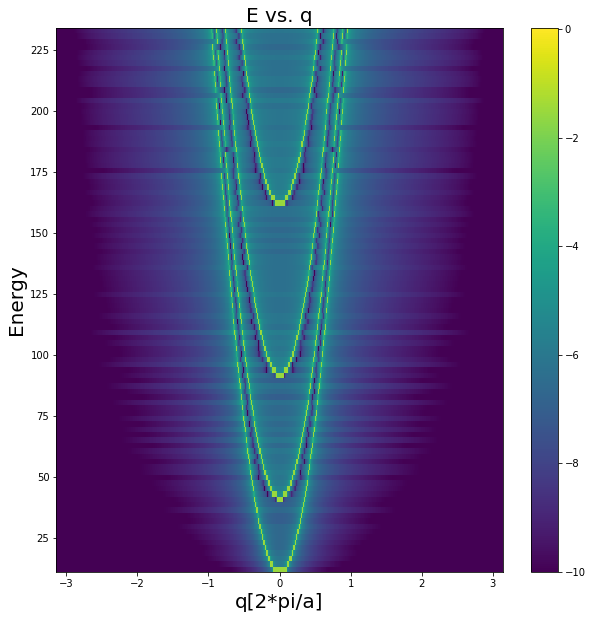

In [688]:
a,b,dI_dV3,E3,count = Average_dI_dV_T_linear(abs_evecs[4],evaL[4],np.max(np.diff(evaL[4])))
plot_QPI(dI_dV3,E3,vmin=-10,vmax=0.016)
sio.savemat('b.mat',{'dI_dV':dI_dV3,'avg_energies':E3})

In [663]:
L=3000
a=1.0
total_length=np.zeros(L-1)
def Trapazoide(pos):
    (x, y) = pos
    return ((0 <= x < L) and (0 <= y < (((w2-w1)/L)*x+w1)))
lat = kwant.lattice.square(a)
aa=lat.shape(Trapazoide, (L-1,1))
AA=list(aa())
#density_per_energy = np.zeros(eve.shape)
for i in range(len(AA)):
#Counting the length of each collun
    T=AA[i];
    (x,y)=T[1];
    total_length[x-1]=total_length[x-1]+1

In [675]:
total_length[-100:-1]

array([ 30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,
        30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,
        30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,
        30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,
        30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,
        30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,
        30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,
        30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,
        30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.])

In [661]:
sio.savemat('a.mat',{'dI_dV':dI_dV,'avg_energies':avg_energies})

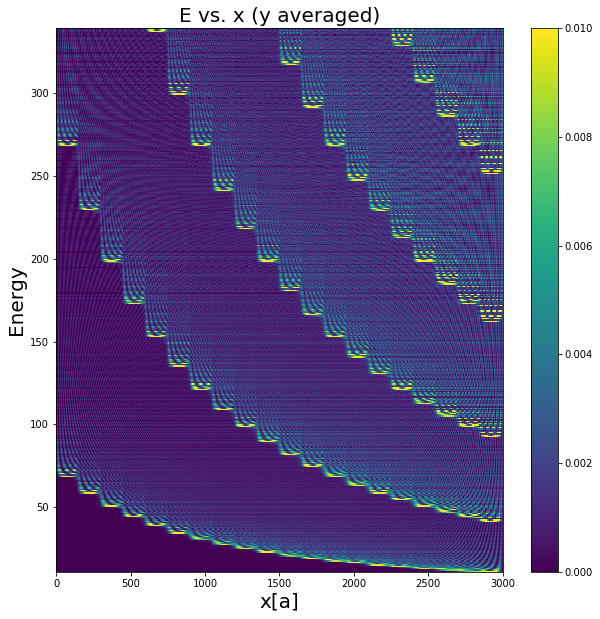

In [660]:
X,dE,dI_dV, avg_energies,energies_count = Average_dI_dV_T_linear(abs_evecsT[5],evaT[5],np.max(np.diff(evaT[5])))
plot_spectra(dI_dV,avg_energies,vmin=0,vmax=0.01)

In [604]:
energies_count

array([   22.64759149,    24.31453062,    38.58828537,    27.63633868,
          43.15718327,    45.74163615,    32.27453689,    49.84784272,
          52.39173212,    54.66175143,    57.19244723,    59.44210657,
          62.00044889,    64.16472749,    44.4989932 ,    91.30651999,
          71.38290029,    49.35816595,    75.61230417,    77.83239569,
          80.3794444 ,    83.07029401,    85.20614624,    58.51227855,
          89.57230383,    92.29412817,    94.46001315,    64.68650239,
          98.83328891,    67.80753196,   138.04886609,    71.13993307,
         108.26000248,    74.09274385,   113.03001053,    77.37573851,
         117.56104265,   120.05340414,    81.78793561,   166.00473152,
         127.39247397,    86.4671994 ,   131.66184579,   222.229855  ,
         136.3086253 ,   138.50749479,   187.6771035 ,   143.04983189,
         145.24045479,   147.45408121,   199.81044294,   253.90407918,
         155.10079707,   156.79353851,   212.12718108,   161.71121623,
      

ModuleNotFoundError: No module named 'dill'

/home/tom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


array([], dtype=float64)

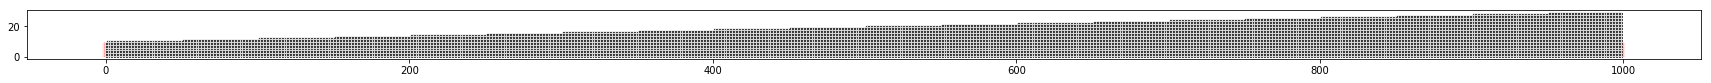

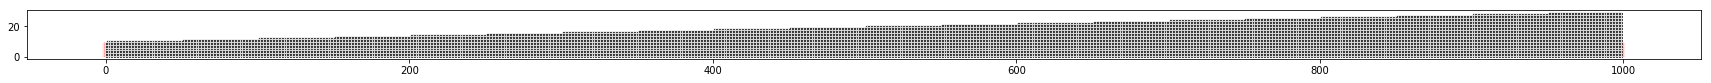

In [535]:
kwant.plot(sysT[4],fig_size=(30,200))

In [566]:
[1,2,3]/[5,3,4]

TypeError: unsupported operand type(s) for /: 'list' and 'list'

In [571]:
AAA=[1,2,3]
BBB=[5,3,4]
AAA/BBB[:,None]

TypeError: list indices must be integers or slices, not tuple

In [572]:
from operator import truediv as tv

In [574]:
map(tv,AAA,BBB)